## Setup 

In [8]:
import jax.numpy as jnp
import jax3dp3 as j
import trimesh
import os
import numpy as np
import trimesh
import jax
import cv2


# --- creating the model dir from the working directory
model_dir = os.path.join(j.utils.get_assets_dir(), "ycb_video_models/models")
print(f"{model_dir} exists: {os.path.exists(model_dir)}")
model_names = j.ycb_loader.MODEL_NAMES
model_paths = [os.path.join(model_dir,name,"textured.obj") for name in model_names]

bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)
intrinsics = j.Intrinsics(
    height=rgbd.intrinsics.height,
    width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2.0, cy=rgbd.intrinsics.height/2.0,
    near=0.001, far=3.0
)

/home/ubuntu/jax3dp3/assets/ycb_video_models/models exists: True


In [2]:
renderer = j.Renderer(rgbd.intrinsics, num_layers=25)
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")
model_names = ["obj_" + f"{str(idx+1).rjust(6, '0')}.ply" for idx in range(21)]
mesh_paths = []
for name in model_names:
    mesh_path = os.path.join(model_dir,name)
    mesh_paths.append(mesh_path)
    model_scaling_factor = 1.0/1000.0
    renderer.add_mesh_from_file(
        mesh_path,
        scaling_factor=model_scaling_factor
    )

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (640, 480, 25)


In [3]:
camera_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.5, 0.5, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)
object_pose = j.t3d.inverse_pose(camera_pose)
object_pose2 = object_pose @ j.t3d.transform_from_pos(jnp.array([0.1, 0.1, 0.0]))
object_poses = jnp.array([object_pose, object_pose2])
IDX = 13
IDX2 = 14

In [4]:
all_data = j.kubric_interface.render_multiobject_parallel([model_paths[IDX],model_paths[IDX2]], object_poses[:,None,...], intrinsics, scaling_factor=1.0, lighting=3.0) # multi img singleobj

path:
/home/ubuntu/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/ubuntu/jax3dp3:/home/ubuntu/jax3dp3 --volume /tmp:/tmp   --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill  kubricdockerhub/kubruntu /usr/bin/python3 /home/ubuntu/jax3dp3/jax3dp3/photorealistic_renderers/kubric_exec_parallel.py
['/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug/textured.obj'
 '/home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill/textured.obj']
POSES: [[[array([-2.1782039e-15, -4.3964008e-08,  8.6602539e-01], dtype=float32)
   array([ 0.1759199 ,  0.33985114,  0.82047325, -0.4247082 ], dtype=float32)]
  [array([-3.4166794e-09,  8.1649609e-02,  7.5055534e-01], dtype=float32)
   array([ 0.1759199 ,  0.33985114,  0.82047325, -

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmp6zabfo_5'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmp6zabfo_5/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 1, total unfreed memory 0.001259 MB


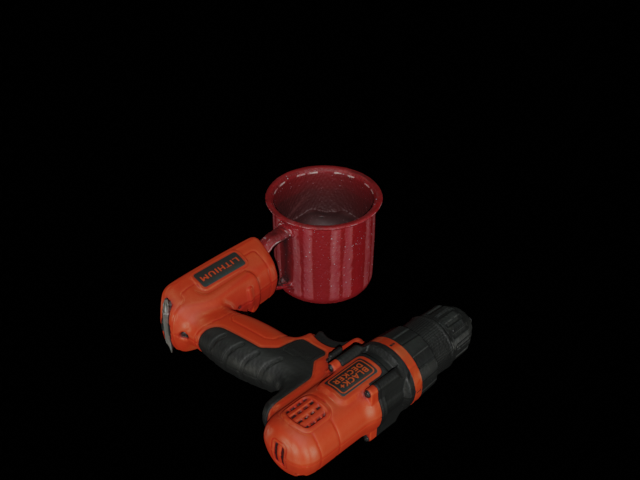

In [5]:
rgbd = all_data[0]
j.get_rgb_image(rgbd.rgb)

In [32]:
# function taking the rbgd rgb and intrinstics as well as the renderer and returning the cosypose prediction 
def cosypose_pred(rgb, intrinsics, renderer):
    pred = j.cosypose_utils.cosypose_interface(rgb, j.K_from_intrinsics(intrinsics))
    pred_poses, pred_ids, pred_scores = pred['pred_poses'], pred['pred_ids'], pred['pred_scores']
    rendered = renderer.render_multiobject(jnp.array(pred_poses[0]), jnp.array(pred_ids[0]))
    return j.get_depth_image(rendered[:,:,2]) 

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


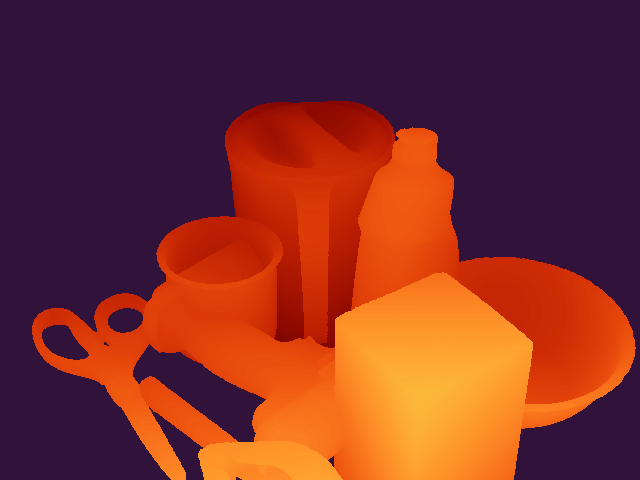

In [33]:
cosypose_pred(rgbd.rgb, rgbd.intrinsics, renderer)

## Breaking CosyPose, Image Variations

1. lighting variations or illumination changes
2. Gaussian noise to rgb or low resolution (failing)
    - Reconstruction breaks down even with 0.5 scaling 
3. Partially off screen (passing)
4. Partially occluded by another object (passing)
5. Complex Backgrounds
6. Warping 
7. Others 
    6.1. Multiple Identical Objects: Passes 

### gaussian noise, low resolution 

In [11]:
def add_gaussian_noise(img, mean=0, variance=100):
    """
    Add Gaussian noise to an image.

    Parameters:
    img (numpy.ndarray): Input image as a NumPy array.
    mean (float, optional): Mean of the Gaussian noise. Default is 0.
    variance (float, optional): Variance of the Gaussian noise. Default is 0.1.

    Returns:
    numpy.ndarray: The noisy image as a NumPy array.
    """
    # Add Gaussian noise
    noise = np.random.normal(mean, variance**0.5, img.shape)
    noisy_img = np.clip(img + noise, 0, 255).astype(np.uint8)

    return noisy_img

def make_low_resolution(img, scale_factor=0.5):
    """
    Create a low-resolution version of an image by downsampling and upsampling.

    Parameters:
    img (numpy.ndarray): Input image as a NumPy array.
    scale_factor (float, optional): The scale factor to downsample and upsample the image. Default is 0.5.

    Returns:
    numpy.ndarray: The low-resolution image as a NumPy array.
    """
    # Downsample the image
    downsampled_img = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)

    # Upsample the image
    low_res_img = cv2.resize(downsampled_img, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

    return low_res_img

In [9]:
camera_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.5, 0.5, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)
# object poses in camera frame
object_pose = j.t3d.inverse_pose(camera_pose)

# list of positions from 0.1, 0.1 to 0.2, 0.2
poses_list = []
for i in range(3):
    for k in range(3):
        poses_list.append(object_pose @ j.t3d.transform_from_pos(jnp.array([0.1*i, 0.1*k, 0.0])))

object_poses = jnp.array(poses_list)

# testing a variety of models 
idx_list = [i for i in range(10,19)]
m_paths = [] 
for idx in idx_list:
    m_paths.append(model_paths[idx])

path:
/home/ubuntu/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/ubuntu/jax3dp3:/home/ubuntu/jax3dp3 --volume /tmp:/tmp   --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/019_pitcher_base:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/019_pitcher_base  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/021_bleach_cleanser:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/021_bleach_cleanser  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/024_bowl:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/024_bowl  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/036_wood_block:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/036

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpm1zq9hw7'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpm1zq9hw7/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 1, total unfreed memory 0.001259 MB


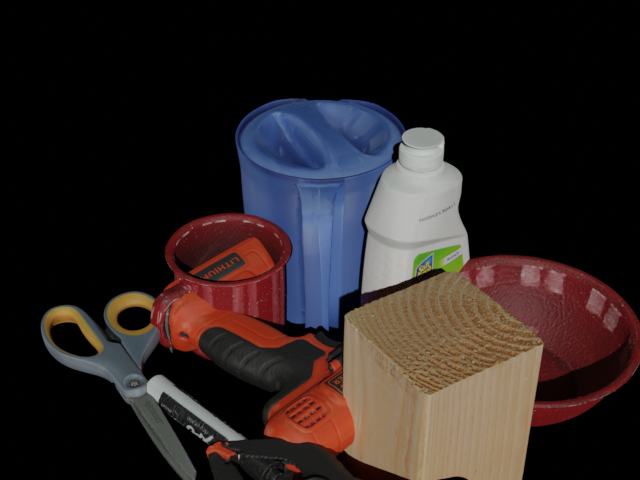

In [10]:
all_data = j.kubric_interface.render_multiobject_parallel(m_paths, object_poses[:,None,...], intrinsics, scaling_factor=1.0, lighting=3.0) # multi img singleobj
rgbd = all_data[0]
j.get_rgb_image(rgbd.rgb)

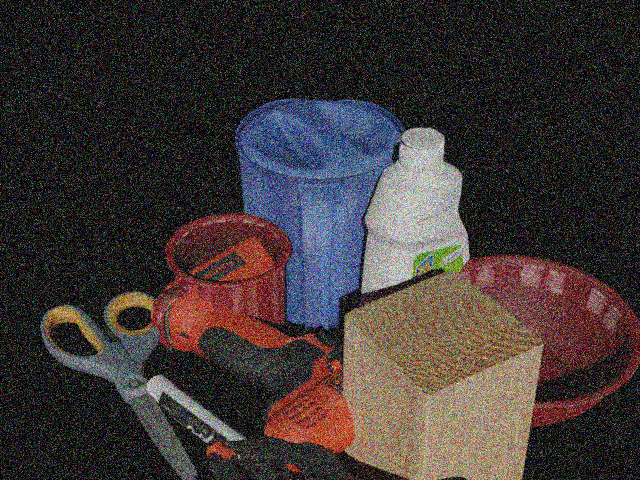

In [37]:
gauss = add_gaussian_noise(rgbd.rgb, variance=1200)
j.get_rgb_image(gauss)

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


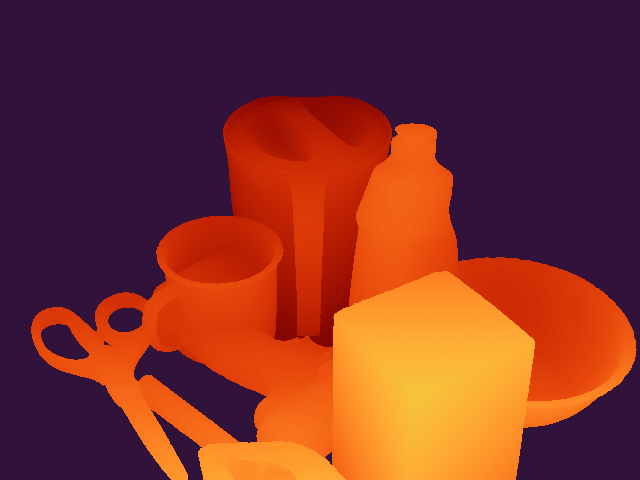

In [38]:
cosypose_pred(gauss, rgbd.intrinsics, renderer)

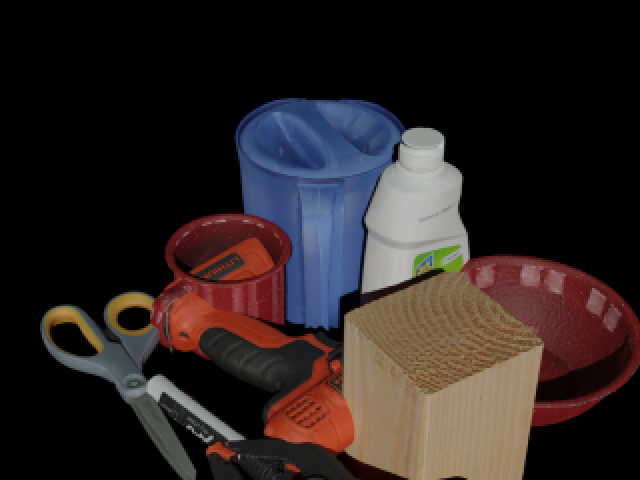

In [24]:
low_res = make_low_resolution(rgbd.rgb, scale_factor=.5)
j.get_rgb_image(low_res)

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


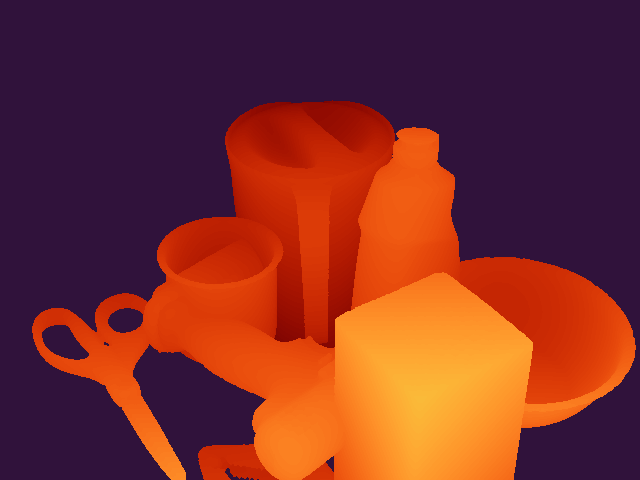

In [39]:
cosypose_pred(low_res, rgbd.intrinsics, renderer)

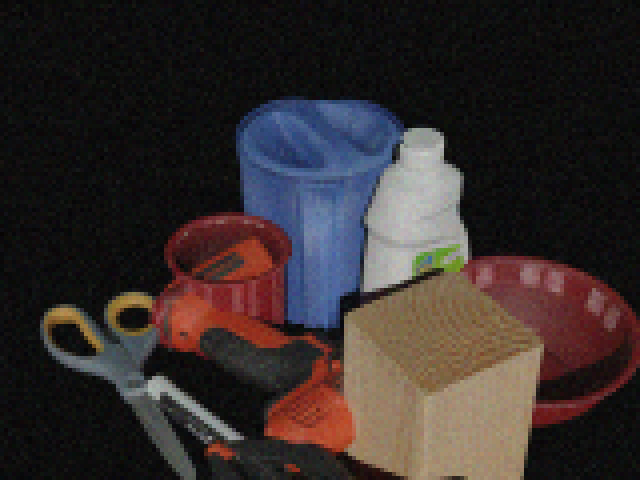

In [20]:
gauss_low_res = make_low_resolution(gauss, scale_factor=.25)
low_res_gauss = add_gaussian_noise(low_res, variance=300)
j.get_rgb_image(gauss_low_res)

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


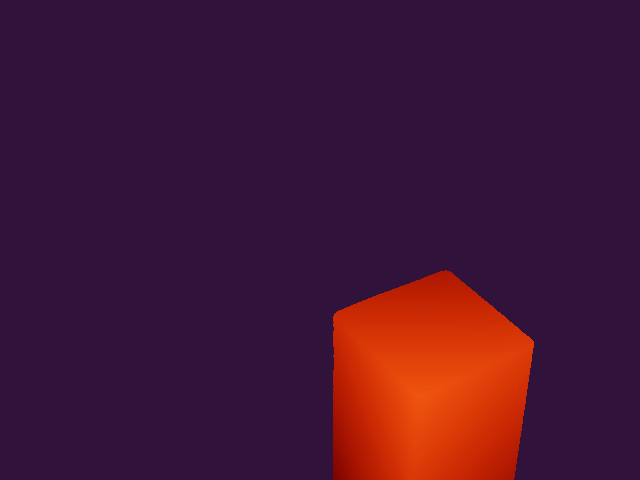

In [26]:
cosypose_pred(gauss_, rgbd.intrinsics, renderer)

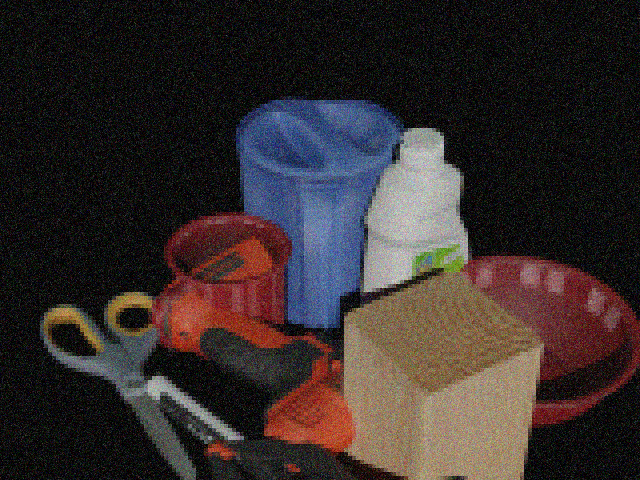

In [22]:
j.get_rgb_image(low_res_gauss)

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


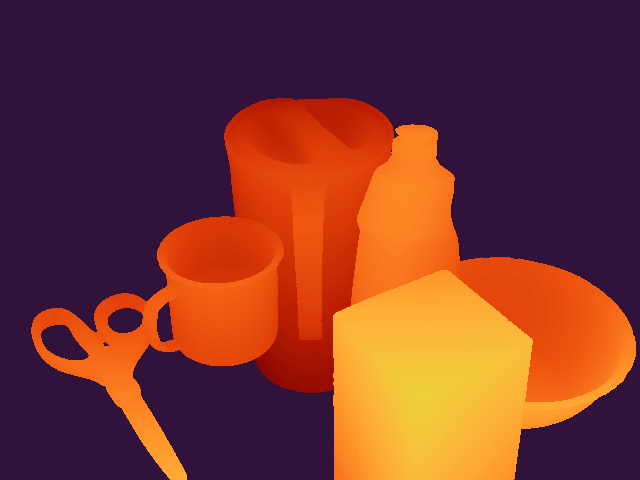

In [27]:
pred = j.cosypose_utils.cosypose_interface(low_res_gauss, j.K_from_intrinsics(rgbd.intrinsics))
pred_poses, pred_ids, pred_scores = pred['pred_poses'], pred['pred_ids'], pred['pred_scores']
rendered = renderer.render_multiobject(jnp.array(pred_poses[0]), jnp.array(pred_ids[0]))
j.get_depth_image(rendered[:,:,2])

### Partially Occuluded

In [3]:
import jax.numpy as jnp
import jax3dp3 as j
import trimesh
import os
import numpy as np
import trimesh
import jax


# --- creating the model dir from the working directory
model_dir = os.path.join(j.utils.get_assets_dir(), "ycb_video_models/models")
print(f"{model_dir} exists: {os.path.exists(model_dir)}")
model_names = j.ycb_loader.MODEL_NAMES
model_paths = [os.path.join(model_dir,name,"textured.obj") for name in model_names]

bop_ycb_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv")
rgbd, gt_ids, gt_poses, masks = j.ycb_loader.get_test_img('52', '1', bop_ycb_dir)
intrinsics = j.Intrinsics(
    height=rgbd.intrinsics.height,
    width=rgbd.intrinsics.width,
    fx=rgbd.intrinsics.fx, fy=rgbd.intrinsics.fx,
    cx=rgbd.intrinsics.width/2.0, cy=rgbd.intrinsics.height/2.0,
    near=0.001, far=3.0
)
renderer = j.Renderer(rgbd.intrinsics, num_layers=25)
model_dir = os.path.join(j.utils.get_assets_dir(), "bop/ycbv/models")
model_names = ["obj_" + f"{str(idx+1).rjust(6, '0')}.ply" for idx in range(21)]
mesh_paths = []
for name in model_names:
    mesh_path = os.path.join(model_dir,name)
    mesh_paths.append(mesh_path)
    model_scaling_factor = 1.0/1000.0

/home/ubuntu/jax3dp3/assets/ycb_video_models/models exists: True


In [29]:
#poses
camera_pose = j.t3d.transform_from_pos_target_up(
    jnp.array([0.5, 0.5, 0.5]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)
# object poses in camera frame
object_pose = j.t3d.inverse_pose(camera_pose)

# list of positions from 0.1, 0.1 to 0.2, 0.2
poses_list = []
for i in range(3):
    for k in range(3):
        poses_list.append(object_pose @ j.t3d.transform_from_pos(jnp.array([0.1*i, 0.1*k, 0.0])))

object_poses = jnp.array(poses_list)

# model paths 
# a list from one to nine 
idx_list = [i for i in range(10,19)]

#add model paths to list based on idx_list
m_paths = [] 
for idx in idx_list:
    m_paths.append(model_paths[idx])

path:
/home/ubuntu/jax3dp3
sudo docker run --rm --interactive --user $(id -u):$(id -g) --volume /home/ubuntu/jax3dp3:/home/ubuntu/jax3dp3 --volume /tmp:/tmp   --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/019_pitcher_base:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/019_pitcher_base  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/021_bleach_cleanser:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/021_bleach_cleanser  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/024_bowl:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/024_bowl  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/025_mug  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/035_power_drill  --volume /home/ubuntu/jax3dp3/assets/ycb_video_models/models/036_wood_block:/home/ubuntu/jax3dp3/assets/ycb_video_models/models/036

INFO:kubric.renderer.blender:Using scratch rendering folder: '/tmp/tmpg3l7z0qq'
INFO:kubric.renderer.blender:Rendered frame '/tmp/tmpg3l7z0qq/images/frame_0001.png'


RENDERED FRAME 
SAVED FRAME USING NP
Error: Not freed memory blocks: 1, total unfreed memory 0.001259 MB


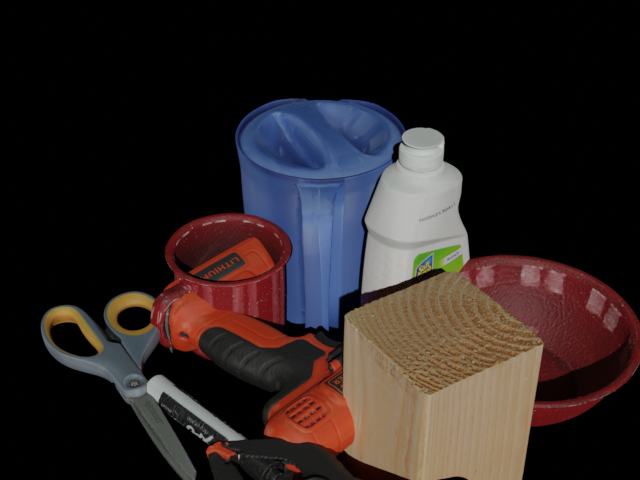

In [30]:
all_data = j.kubric_interface.render_multiobject_parallel(m_paths, object_poses[:,None,...], intrinsics, scaling_factor=1.0, lighting=3.0) # multi img singleobj
rgbd = all_data[0]
j.get_rgb_image(rgbd.rgb)

In [31]:
pred = j.cosypose_utils.cosypose_interface(np.array(rgbd.rgb), j.K_from_intrinsics(rgbd.intrinsics))
pred_poses, pred_ids, pred_scores = pred['pred_poses'], pred['pred_ids'], pred['pred_scores']

Entering COSYPOSE
/opt/conda/envs/cosypose/bin/python


pybullet build time: May 20 2022 19:43:01
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:136: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/envs/cosypose/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.

Finished COSYPOSE


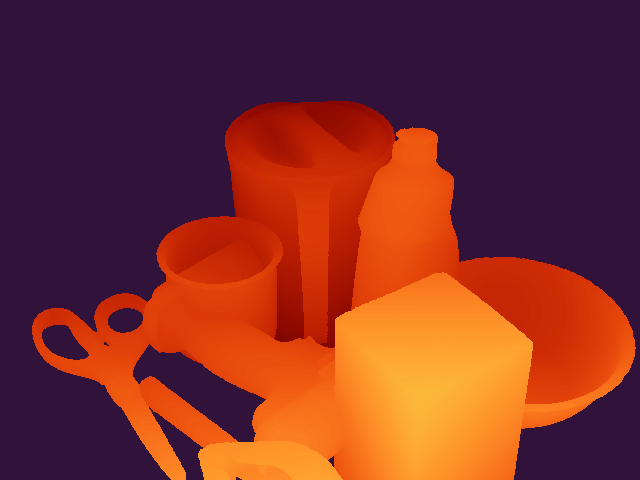

In [32]:
rendered = renderer.render_multiobject(jnp.array(pred_poses[0]), jnp.array(pred_ids[0]))
j.get_depth_image(rendered[:,:,2])